In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
import cv2
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score
import segmentation_models_pytorch as smp

folder_path = "PTUMOUSE"

seed_value = 52
torch.manual_seed(seed_value)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

C:\Users\naida\PycharmProjects\COMPUTER-VISION\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [22]:
train_df = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

In [24]:
def calculate_iou(predictions, targets):
    total_sum = 0.0
    for prediction, target in zip(predictions, targets):
        intersection = np.logical_and(prediction, target).sum().item()
        union = np.logical_or(prediction, target).sum().item()
        
        total_sum += intersection / union if union > 0 else 0.0

    return total_sum / len(predictions)

In [25]:
def ap_k(predictions, targets, k, klass):
    precision = 0
    tp = 0
    all_det = 0
    for i in range(k):
        predict = predictions[i]
        target = targets[i]

        if klass:
            tp += np.sum(predict[predict == target])
            all_det += np.sum(predict)
            precision += tp / all_det
        else:
            tp += len(predict[predict == target]) - np.count_nonzero(predict[predict == target])
            all_det += predict.size - np.count_nonzero(predict)
            precision += tp / all_det
    return precision / k 

def compute_ap(predictions, targets, k):
    return (ap_k(predictions, targets, k, True) + ap_k(predictions, targets, k, False)) / 2, ap_k(predictions, targets, k, True)



In [ ]:
def compute_precision_recall(predicted_masks, ground_truth_masks):
    predicted_masks_flat = predicted_masks.flatten()
    ground_truth_masks_flat = ground_truth_masks.flatten()
    precision = precision_score(ground_truth_masks_flat, predicted_masks_flat)
    recall = recall_score(ground_truth_masks_flat, predicted_masks_flat)
    return precision, recall

### Preprocessing (подготовка данных)

In [27]:
class ImagesDataset(Dataset):
    def __init__(self, folder, data, transform_image, transform_mask):
      self.folder = folder
      self.data = data.copy()
      self.orig_image_paths = [os.path.join(folder, filename) for filename in data['orig_image'].copy()]
      self.mask_image_paths = [os.path.join(folder, filename) for filename in data['mask_image'].copy()]
      self.transform_image = transform_image
      self.transform_mask = transform_mask

    def __len__(self):
        return len(self.orig_image_paths)

    def __getitem__(self, idx):
        orig_image_path = self.orig_image_paths[idx]
        mask_image_path = self.mask_image_paths[idx]
        orig_image = Image.open(orig_image_path).convert('RGB')
        mask_image = Image.open(mask_image_path).convert('L')
        
        orig_image = self.transform_image(orig_image)
        orig_image = orig_image.to(orig_image)
        
        mask_image = self.transform_mask(mask_image)
        mask_image = mask_image.to(mask_image)
        
        return orig_image.float(), mask_image.float()

In [28]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size=0.1 , random_state=42)

size = (320, 544)
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
batch_size = 8

transform_image = transforms.Compose([transforms.Resize(size), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

transform_mask = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

train_dataset = ImagesDataset(folder_path, train, transform_image, transform_mask)
val_dataset = ImagesDataset(folder_path, val, transform_image, transform_mask)
test_dataset = ImagesDataset(folder_path, test, transform_image, transform_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Training/evaluation loop

In [29]:
def learning(num_epochs, train_load, val_load, model, optimizer, criterion, model_name, scheduler=None):
  train_losses = []
  val_losses = []
  iou_test = []
  max_iou = 0.0

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in tqdm(train_load):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_load))
    
    if scheduler is not None:
      scheduler.step(loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in tqdm(val_load):
          x_batch, y_batch = x_batch.to(device), y_batch.to(device)
          outputs = model(x_batch)
          loss = criterion(outputs, y_batch)
          val_loss += (loss.item())
    val_losses.append(val_loss/len(val_load))

    predictions, _, orig_masks, _ = prediction(model, test_loader)
    iou = calculate_iou(predictions, orig_masks)
    iou_test.append(iou)

    if iou > max_iou and iou > 0.87:
       max_iou = iou
       torch.save(model.state_dict(), f"models/{model_name}_IOU-{iou}.pth")

    print(f"Epoch [{epoch+1}/{num_epochs}], Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, IOU: {iou:.4f}")
  return model, train_losses, val_losses, iou_test

### Prediction function

In [30]:
def prediction(model, loader):
    model.eval()
    predictions = []
    orig_images = []
    orig_masks = []
    intersection_masks = []
    size = (544, 928)
    transform = transforms.Compose([transforms.Resize(size)])
    with torch.no_grad():
        for x_batch, y_batch in tqdm(loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            new_outputs = torch.zeros(outputs.shape[0], outputs.shape[1], outputs.shape[2], outputs.shape[3])
            outputs[outputs < 0] = 0
            outputs[outputs > 0] = 1

            outputs = transform(outputs)
            x_batch = transform(x_batch)
            y_batch = transform(y_batch)

            outputs = torch.round(outputs)
            y_batch = torch.round(y_batch)

            predictions.append(outputs.cpu().numpy())
            orig_images.append(x_batch.cpu().numpy())
            orig_masks.append(y_batch.cpu().numpy())

            intersection = np.abs(outputs.cpu().numpy() - y_batch.cpu().numpy())
            intersection_masks.append(intersection)
    predictions = np.concatenate(predictions, axis=0).squeeze()
    orig_images = np.concatenate(orig_images, axis=0).squeeze()
    orig_masks = np.concatenate(orig_masks, axis=0).squeeze()
    intersection_masks = np.concatenate(intersection_masks, axis=0).squeeze()
    return predictions, orig_images, orig_masks, intersection_masks

In [44]:
def validation(model, loader):
    predictions, orig_images, orig_masks, intersection_masks = prediction(model, loader)

    iou = calculate_iou(predictions, orig_masks)
    apk, ap = compute_ap(predictions, orig_masks, len(predictions))
    precision, recall = compute_precision_recall(predictions, orig_masks)
    print(f"IOU: {iou}")
    print(f"Precision: {precision}, Recall: {recall}")

### Experiments

In [32]:
model_name = 'efficientnet-b3'
model = smp.UnetPlusPlus(encoder_name=model_name, encoder_weights='imagenet', in_channels=3, classes=1)
model.to(device)


UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticS

In [33]:
import segmentation_models_pytorch as smp

learning_rate = 0.001
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
criterion = smp.losses.DiceLoss(mode='binary')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [34]:
num_epochs = 20 
model, train_losses, val_losses, iou_test = learning(num_epochs, train_loader, val_loader, model, optimizer, criterion, model_name, scheduler)

100%|██████████| 2/2 [00:00<00:00, 11.63it/s]


Epoch [1/20], Train loss: 94.0236, Val loss: 2.5778, IOU: 0.8345


100%|██████████| 2/2 [00:00<00:00, 12.46it/s]


Epoch [2/20], Train loss: 17.7910, Val loss: 1.8009, IOU: 0.8504


100%|██████████| 2/2 [00:00<00:00, 12.76it/s]


Epoch [3/20], Train loss: 15.0046, Val loss: 1.6484, IOU: 0.8608


100%|██████████| 2/2 [00:00<00:00, 12.75it/s]


Epoch [4/20], Train loss: 13.7497, Val loss: 1.5501, IOU: 0.8640


100%|██████████| 2/2 [00:00<00:00, 12.72it/s]


Epoch [5/20], Train loss: 12.7394, Val loss: 1.4367, IOU: 0.8651


100%|██████████| 2/2 [00:00<00:00, 12.79it/s]


Epoch [6/20], Train loss: 11.8669, Val loss: 1.3451, IOU: 0.8659


100%|██████████| 2/2 [00:00<00:00, 12.66it/s]


Epoch [7/20], Train loss: 11.1503, Val loss: 1.3322, IOU: 0.8597


100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


Epoch [8/20], Train loss: 10.8330, Val loss: 1.2978, IOU: 0.8572


100%|██████████| 2/2 [00:00<00:00, 11.90it/s]


Epoch [9/20], Train loss: 10.5621, Val loss: 1.2781, IOU: 0.8614


100%|██████████| 2/2 [00:00<00:00, 12.80it/s]


Epoch [10/20], Train loss: 10.1574, Val loss: 1.2092, IOU: 0.8597


100%|██████████| 2/2 [00:00<00:00, 12.60it/s]


Epoch [11/20], Train loss: 9.7863, Val loss: 1.2474, IOU: 0.8625


100%|██████████| 2/2 [00:00<00:00, 12.78it/s]


Epoch [12/20], Train loss: 9.6465, Val loss: 1.2043, IOU: 0.8620


100%|██████████| 2/2 [00:00<00:00, 11.53it/s]


Epoch [13/20], Train loss: 9.5202, Val loss: 1.2245, IOU: 0.8622


100%|██████████| 2/2 [00:00<00:00, 12.76it/s]


Epoch [14/20], Train loss: 9.4034, Val loss: 1.1740, IOU: 0.8602


100%|██████████| 2/2 [00:00<00:00, 12.80it/s]


Epoch [15/20], Train loss: 9.3324, Val loss: 1.2998, IOU: 0.8622


100%|██████████| 2/2 [00:00<00:00, 12.48it/s]


Epoch [16/20], Train loss: 9.1145, Val loss: 1.1381, IOU: 0.8615


100%|██████████| 2/2 [00:00<00:00, 13.38it/s]


Epoch [17/20], Train loss: 8.9057, Val loss: 1.1424, IOU: 0.8642


100%|██████████| 2/2 [00:00<00:00, 12.80it/s]


Epoch [18/20], Train loss: 8.8718, Val loss: 1.1299, IOU: 0.8594


100%|██████████| 2/2 [00:00<00:00, 11.62it/s]


Epoch [19/20], Train loss: 8.8276, Val loss: 1.1362, IOU: 0.8654


100%|██████████| 2/2 [00:00<00:00, 12.80it/s]


Epoch [20/20], Train loss: 8.8045, Val loss: 1.1199, IOU: 0.8685


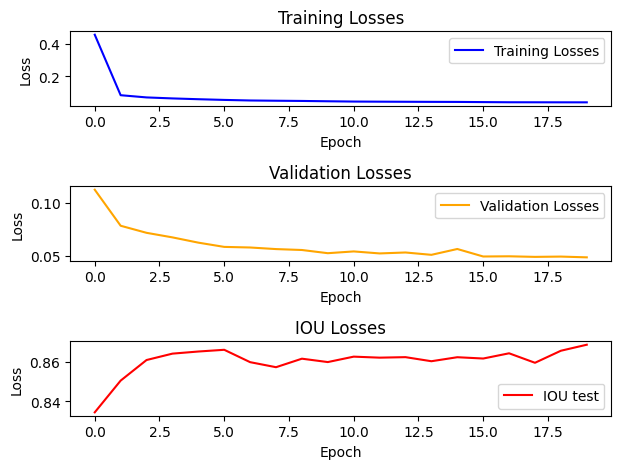

In [35]:
plt.subplot(3, 1, 1)
plt.plot(train_losses, label='Training Losses', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(val_losses, label='Validation Losses', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(iou_test, label='IOU test', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('IOU Losses')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluation (оценка качества модели)

In [ ]:
validation(model, train_loader)

 19%|█▉        | 72/375 [00:22<01:25,  3.54it/s]

: 

In [45]:
validation(model, val_loader)

100%|██████████| 23/23 [00:03<00:00,  6.46it/s]


IOU: 0.92281819407803
Precision: 0.9624645045194978, Recall: 0.9973820316996359


In [46]:
validation(model, test_loader)

100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


IOU: 0.868471487981789
Precision: 0.9324459506359349, Recall: 0.9678053140489152
